## **Dipole-Model Reflectarray - Tutorial Notebook**

Illustrates the design (inverse model) and analysis/prediction (forward model) of a grayscale reflectarray using a point dipole model.  
The reflectarray dipole model is described in https://ieeexplore.ieee.org/abstract/document/10045765 (and its cited references).

### Import libraries

Dipole-model reflectarray Python code can be downloaded from https://github.com/aaronvd/dipole-model-reflectarray

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.constants
import sys
sys.path.append('..')               # if necessary, replace this with the path to the reflectarray git repository folder
from reflectarray import element
from reflectarray.reflectarray import Reflectarray
from reflectarray.feed import Feed
from reflectarray.feed import PyramidalHorn
from reflectarray.system import System

# 'inline' displays plots in the notebook. Can alternatively specify 'qt' to plot in external windows.
%matplotlib inline

### Define operating frequency and reflectarray unit element (patch)

In the following cell we define a patch element, which can be modelled as two magnetic dipoles over a ground plane.  

<center><img src="figures/patch-dipoles.png">

Here, each dipole is defined analytically according to a Lorentzian resonator description:  

$$ \alpha=\frac{F\omega^2}{\omega_0^2-\omega^2+j\gamma\omega} $$  

$\omega_0$ is the resonance frequency, and $\omega$ is the operating frequency. $F$ is the coupling strength, and $\gamma=\omega_0 / 2Q$ is the damping factor.

The lattice vector direction specifies the polarization of the magnetic dipoles, determined by the geometry of the patch.  

We specify a range of tuning states (corresponding to, e.g., different patch geometries or varactor capacitance values) at the operating frequency. This gives us a "dictionary" of available element values (phase and magnitude) that we'll use later to design the reflectarray.

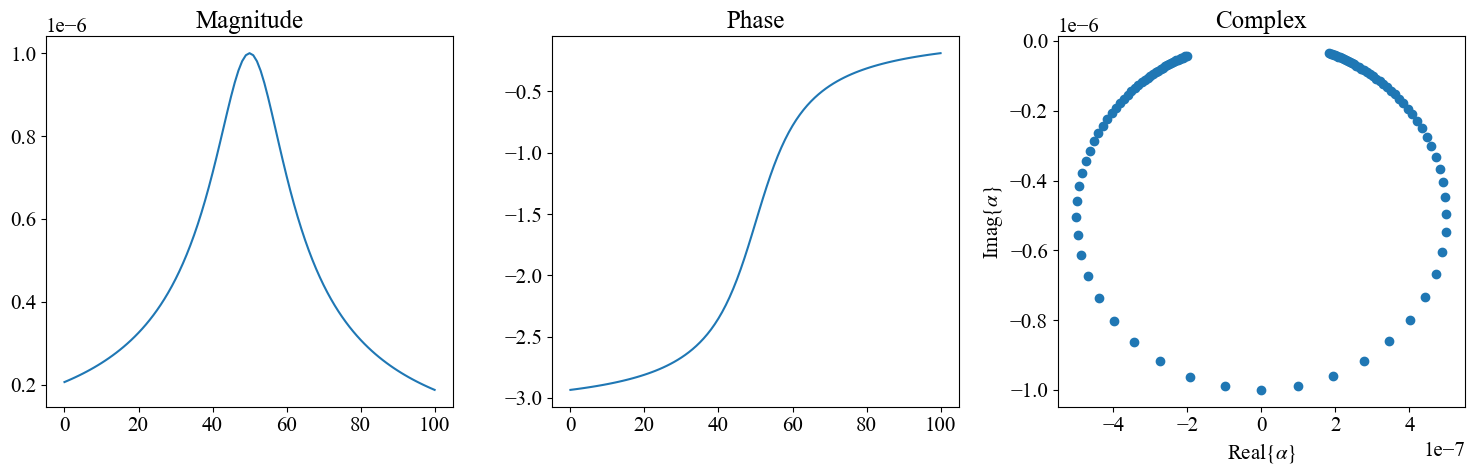

In [2]:
C = scipy.constants.c
f = 10E9
lam = C / f

patch1 = element.Patch(f=f, 
                       Q=25,                                    # Quality (Q) factor. Higher number means sharper resonance
                       lattice_vectors=np.array([[0, 1, 0]]), 
                       normalize=True)
patch1.alpha = patch1.alpha * 1E-6
patch1.plot()

### Define reflectarray geometry

In the following, we define the reflectarray geometry. A spacing equal to $\lambda / 2$ ensures we can steer the beam over $\pm 90^\circ$ without incurring grating lobes.  

The array size $L$ determines the beamwidth according to 

$$ \mathrm{Beamwidth} \approx \frac{\lambda}{L} \:\:\: (\mathrm{radians})$$ 

Directivity $D(\theta, \phi)$ is a metric that characterizes beam concentration or "focusing" performance. It is defined by  

$$ D(\theta,\phi) = \mathrm{Directivity} = \frac{4\pi U(\theta, \phi)}{P_{rad}} $$  
$$ U(\theta, \phi) = \mathrm{Radiation}\:\mathrm{Intensity}\approx \frac{r^2}{2\eta} \left[|E_{\theta}|^2 + |E_{\phi}|^2\right]   $$

The maximum achievable directivity of an antenna/array is determined by its size $L$:

$$D_{max} = \frac{4\pi A}{\lambda^2} = \frac{4\pi L^2}{\lambda^2} \:\:\: \mathrm{for}\:\mathrm{a}\:\mathrm{square}\:\mathrm{array}$$

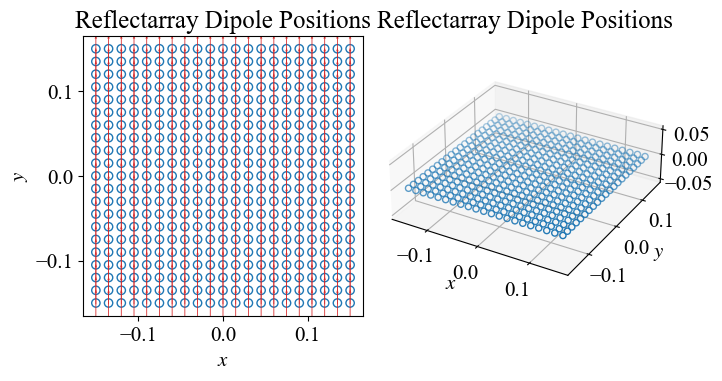

In [3]:
L = 10 * lam
delta_x = lam/2
delta_y = lam/2
x = np.arange(-L/2, L/2+delta_x, delta_x)
y = np.arange(-L/2, L/2+delta_y, delta_y)

fig = plt.figure(figsize=(7,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

array = Reflectarray(patch1, 
                     x=x, 
                     y=y)
array.plot(ax=ax1, show_lattice_vectors=True)

# array.deform(axis='x', R_cylinder=7*lam)         # this will optionally deform the array over a cylindrical surface
array.plot(ax=ax2, show_normals=False, show_lattice_vectors=False)

### Define source

The following cell defines the source which excites the reflectarray. We'll use a pyramidal horn antenna rotated $45^{\circ}$ from the normal and oriented so that the $H$ field is parallel to the $y$ axis (i.e. the defined polarization of the patch elements). We can specify the source gain to later estimate the overall reflectarray system efficiency $e$. Gain ($G$) is related to efficiency by

$$ G = eD $$  

where  

$$ e = \mathrm{Radiation}\: \mathrm{Efficiency} = \frac{P_{out}}{P_{in}} $$  

Gain: 10.00 dB


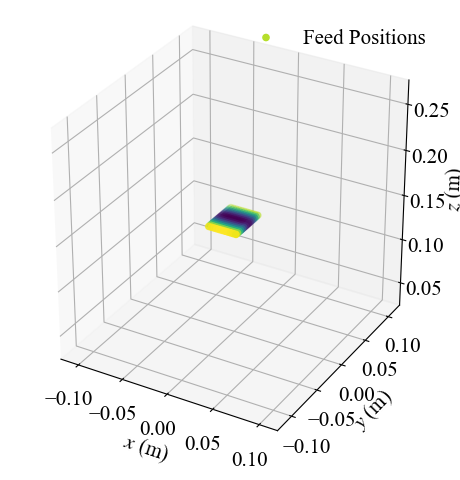

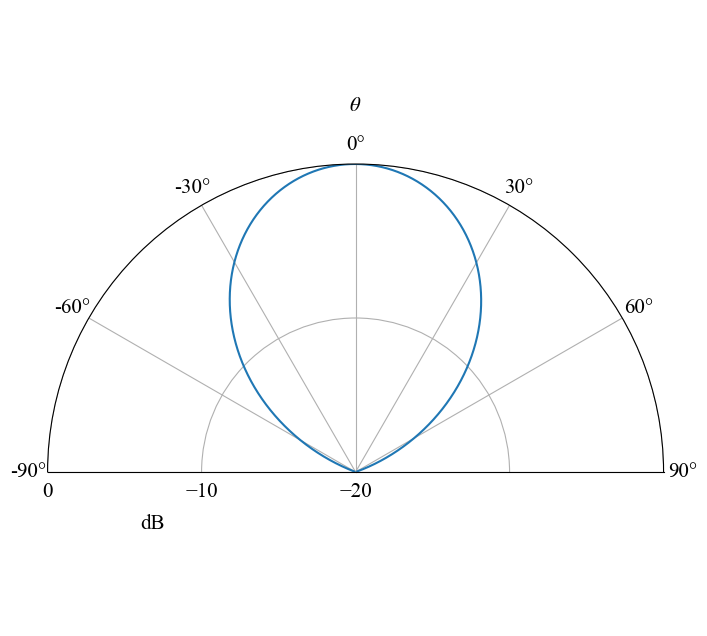

In [4]:
horn = PyramidalHorn(f=f, 
                     E0=1, 
                    #  rotation=(45, 0, 90), 
                     rotation=(0, 0, 90), 
                     r_offset=(0, 0, 5*lam), 
                     gain=10)
_ = horn.compute.calculate_gain()
horn.plot(quiver=False, plot_type='3D', plot_value='J_m')
horn.plot_fields(plot_type='1D', dB_min=-20)

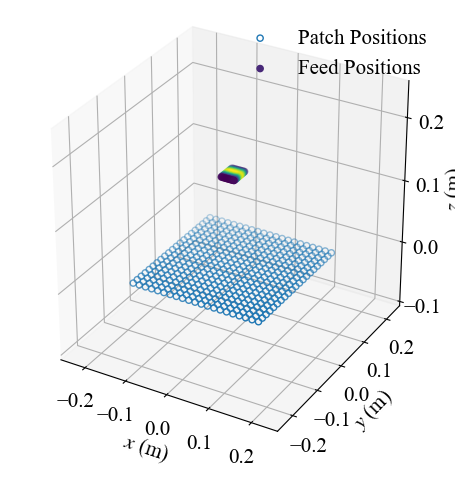

In [5]:
system1 = System(array, horn)
system1.plot()

### Design reflectarray

Now that the reflectarray geometry has been defined, we need to specify a desired beam direction and design the reflectarray (distribution of tuning states) over the antenna surface accordingly. 

To achieve a beam in a given direction in the far field, we need to create a set of currents across the aperture which, when radiating to the far field, "focuses" to a beam in the desired direction $(\theta_0,\phi_0)$. In the conventional reflectarray design procedure, this means we want to place an element at each location which provides a desired phase shift. When added to the phase of source field, the distribution of element phases + source phases over the aperture should result in a plane wave projected onto the surface (recall that the Fourier transform of a plane wave is a delta function; far field propagation can mathematically be described by a Fourier transform). This yields the traditional reflectarray design equation:  

$$ \psi_i = -\psi_{S,i} - \mathbf{k}_b\cdot \mathbf{r}_i + 2\pi N $$  

where  

$ \psi_i = $ desired phase at element position $i$  
$ \psi_{S,i} $ = source field phase at element position $i$  
$ \mathbf{k}_b $ = desired beam wave vector = $\left[ k\mathrm{sin}\theta_0 \mathrm{cos}\phi_0, k\mathrm{sin}\theta_0 \mathrm{sin}\phi_0, k\mathrm{cos}\theta_0 \right] $  
$ \mathbf{r}_i $ = position vector of element $i$  
$ N $ = an integer

This form of the reflectarray design equation accounts only for the phase and a single polarization of the elements. The dipole model is one alternative approach that accommodates more complex scenarios.  

As detailed in the dipole model paper, the design approach is to describe the patch as a pair of dipoles over a ground plane. We can then generate a dictionary of polarizability values and solve for the required dipole values at each patch position (for patches linearly polarized in the $y$ direction):  

$$\alpha_y = \frac{-j\Lambda^2}{\omega \mu_0} \left[\frac{a H_{0y}}{H_{ty}}e^{-j\mathbf{k}_b\cdot\mathbf{r}'} + \eta (\hat{k}_b\cdot\hat{n})\right].$$  

In this equation, $\Lambda$ is the element spacing, $H_{0y}$ is the $y$ component of the desired beam magnitude, $H_{ty}$ is the $y$ component of the total source field (incident + reflected) at the patch element, $\mathbf{r}'$ is the element position, and $\hat{n}$ is the array surface normal.  

The result of this design equation is a prescription for a set of polarizability values over the reflectarray surface. The outputs are unconstrained, so can potentially take on any complex (phase and magnitude) values. In practice, our available element designs provide only a discrete set of phase and/or magnitude values. We must then map the "ideal" outputs of our design equation to the constrained values. This can be done, for example, using a phase-thresholding approach (`mapping='phase'`) or a combined phase-magnitude constraint (`mapping='euclidean`). For comparison, choosing `mapping='ideal'` will use the unconstrained polarizability values that are directly output by the dipole design equation. 

Note that due to the arbitrary constant $a$ in the design equation, there is a scaling freedom to the procedure that can be enforced by modifying `R_far` below.

Computing feed fields...
Computing ideal polarizabilities...
Computing constrained polarizabilities...


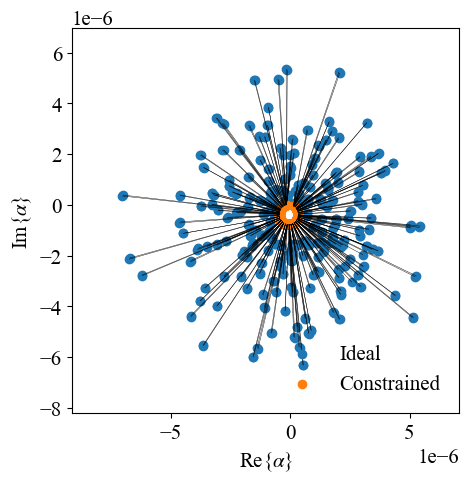

In [45]:
system1.design(theta_beam=45, 
               phi_beam=0, 
               mapping='euclidean',
               scale=.1)
system1.plot_mapping(lattice_index=0, scale=1.3)

We can visualize the reflectarray design by plotting the constrained polarizability values:

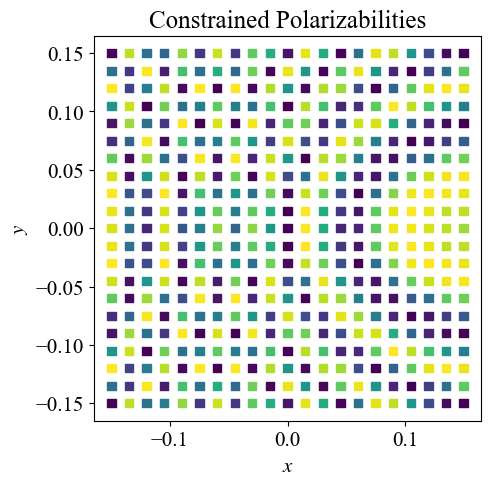

In [46]:
constrained_polarizabilities = system1.alpha_library[system1.alpha_constrained_index[0,:]]

plt.figure(figsize=(5,5))
plt.scatter(array.r[:,0], array.r[:,1], c=np.real(constrained_polarizabilities), cmap='viridis', marker='s')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Constrained Polarizabilities')
plt.show()

### Analyze reflectarray performance

Now that the reflectarray system has been defined (including array size, element spacing, source position and orientation, and element tuning states), we can numerically predict its performance. This is achieved by computing the radiated far field electric field values (using radiation integral expressions found, for instance, in *Balanis, Constantine A. Antenna theory: analysis and design*). To numerically estimate these far field values, we must first convert our distribution of patches to a set of equivalent currents. In the dipole model, we treat the patches as a set of discrete polarizabilities with equivalent magnetic surface currents  

$$ \mathbf{J}_m = \frac{j\omega \mu_0}{\Lambda^2}\bar{\bar{\alpha}}\mathbf{H}_t = \frac{j\omega \mu_0}{\Lambda^2} \alpha_y H_{ty} \hat{y}.$$  

The ground plane additionally contributes a direct reflection of the source which can be described by a set of equivalent electric currents  

$$ \mathbf{J}_e = \hat{n} \times \mathbf{H}_t. $$  

The far field electric field components $E_{\theta}$ and $E_{\phi}$, as well as the required antenna metrics, can then be numerically computed from these equivalent currents.

In [47]:
system1.propagate(delta_theta=1, delta_phi=2)

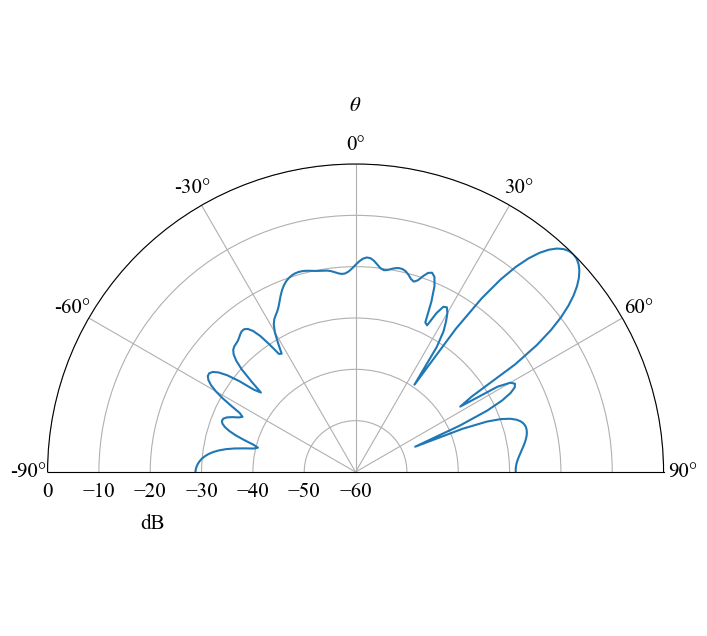

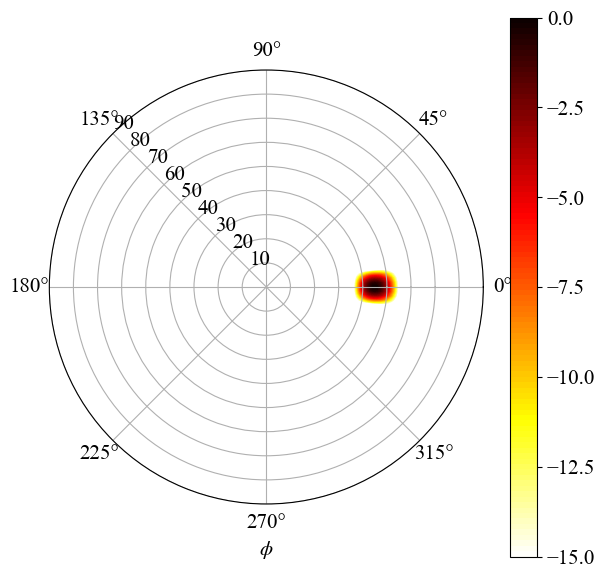

In [48]:
system1.plot_fields(plot_type='1D', phi_slice=0, dB_min=-60)
system1.plot_fields(plot_type='2D', dB_min=-15)

In [17]:
system1.calculate_beam_metrics()        # efficiency will not be accurate unless physical values of the polarizability are used

Beamwidth: 6.37 degrees
Directivity: 27.89 dB
Gain: 29.50 dB
Efficiency: 144.86%
